In [1]:
import math
import pandas as pd
import numpy as np
import time
from datetime import datetime
import copy
import os
import random
from typing import Optional, Any, Union, Callable, Tuple

from models.transformer.my_functrions import make_dataset, get_torch_data_loaders
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter

from ray.tune.search.optuna import OptunaSearch


from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split
from ray import tune
import ray

In [2]:
df = pd.read_csv(
    #'../datasets/prepared/ta_corr_with_logg_diffed.csv',
    '../datasets/prepared/btc/ta_corr_01_fd.csv',
    parse_dates=True
)
target_col = 'log_returns'
df = df.set_index(['timestamp'])
df.index = pd.to_datetime(df.index)
exclude_cols = ['log_close', 'Close']
df

,log_close,Close,log_returns,diff_fear_greed,volatility_kcp,volume_em,volume_vpt,momentum_stoch_rsi,volatility_bbp,momentum_stoch,...,trend_macd_diff,trend_stc,volume_sma_em,trend_aroon_ind,momentum_tsi,trend_aroon_down,trend_vortex_ind_neg,trend_psar_down_indicator,trend_adx_neg,volatility_bbli
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-11-27,5.912611,369.670013,0.003523,-0.006765,0.501327,-40.468161,-3.149466e+05,0.388997,0.425509,34.013853,...,-0.855557,24.373770,-502.853674,36.0,-0.527280,4.0,1.288202,0.0,20.285280,0.0
2014-11-28,5.930777,376.446991,0.018166,0.007878,0.726950,-52.121651,4.515396e+05,0.748693,0.490535,48.927911,...,-0.354460,46.507056,-281.225092,32.0,0.152113,4.0,1.133492,0.0,22.078843,0.0
2014-11-29,5.928234,375.490997,-0.002543,-0.012831,0.700354,927.476194,3.816202e+05,0.714180,0.469128,47.481343,...,-0.099079,68.204734,0.631289,28.0,0.610003,4.0,1.070125,0.0,20.806231,0.0
2014-11-30,5.935019,378.046997,0.006784,-0.003504,0.764513,-196.001510,2.354075e+04,0.813134,0.496233,51.348971,...,0.213258,84.102367,40.733570,20.0,1.277897,8.0,1.032653,0.0,20.063468,0.0
2014-12-01,5.938182,379.244995,0.003164,-0.007124,0.718714,133.611388,9.986327e+04,1.000000,0.504775,69.447910,...,0.457770,92.051184,-12.443357,20.0,1.977937,4.0,1.119928,0.0,19.494893,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29,10.230843,27745.884766,-0.012171,0.987829,1.050246,2858.497078,4.753301e+08,0.811280,0.932253,73.001414,...,142.801589,75.000019,451.343496,-76.0,-8.043034,80.0,0.918640,0.0,18.152938,0.0
2023-05-30,10.229273,27702.349609,-0.001570,-0.001570,0.955887,-624.340933,-2.044453e+08,0.787049,0.897492,71.288406,...,158.821013,87.500010,434.361789,-72.0,-5.906286,76.0,0.923086,0.0,17.383497,0.0
2023-05-31,10.211695,27219.658203,-0.017578,-1.017578,0.580642,-2882.568661,-2.935917e+08,0.526399,0.601630,52.295615,...,132.467667,93.750005,251.374776,-68.0,-5.567434,72.0,0.962587,0.0,22.440350,0.0


In [3]:
#model = tf.keras.models.load_model('checkpoints/lstm_inputs=4,64__lstms=4,64__outputs=4,256.h5', compile=False)
model = tf.keras.models.load_model('checkpoints/lstm_inputs=1,256__lstms=4,32__outputs=0,32.h5', compile=False)

In [4]:
model.compile(
    optimizer='adam',
    loss='mse'
)

In [5]:
ntest=21
horizon=21
timestep=10


Xtrain, Ytrain, Xtest, Ytest, XVal, YVal, scaler = make_dataset(df, target_col='log_returns', exclude_cols=exclude_cols, timestep=timestep, ntest=ntest, horizon=horizon)

X.shape (3080, 10, 36) Y.shape (3080, 21)


In [6]:
preds = model.predict(Xtest)
preds

1/1 [==============================] - 2s 2s/step


array([[-1.13814157e-02, -9.52668209e-03,  3.95544851e-03,
         1.30118392e-02, -7.46212713e-03,  7.72869680e-03,
         1.17329266e-02, -7.35096447e-03,  7.57286558e-04,
         1.35710891e-02,  4.34384262e-03, -4.60134912e-03,
         4.14687442e-03,  3.45585216e-03,  1.45749226e-02,
         1.14644635e-02,  8.85376427e-03, -3.33814649e-03,
         4.95318603e-03, -4.55640489e-04,  7.13539636e-03],
       [-1.10384300e-02, -1.09657710e-02,  1.50533812e-03,
         1.30254887e-02, -4.78599034e-03,  8.95617343e-03,
         1.19412113e-02, -7.48139992e-03, -2.82753864e-03,
         1.38149802e-02,  5.27208066e-03, -1.58829987e-03,
         6.66436367e-03,  3.39522026e-03,  1.37622487e-02,
         1.40850479e-02,  7.54882954e-03, -7.20195007e-04,
         4.22098953e-03, -4.08013258e-03,  5.58195217e-03],
       [-1.07504763e-02, -1.14105605e-02, -1.61536527e-03,
         1.22381626e-02, -2.13701604e-03,  1.04252268e-02,
         8.67013820e-03, -7.24259997e-03, -4.30330914e

22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22


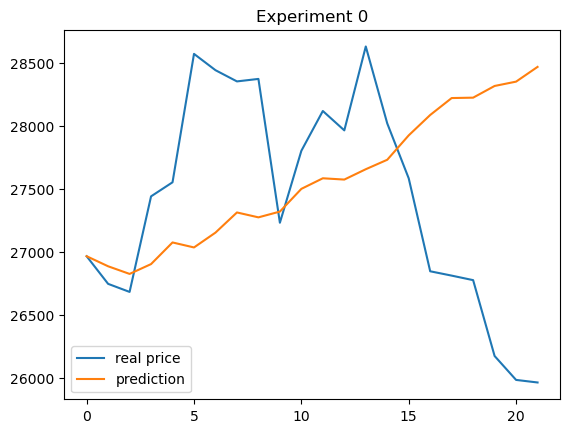

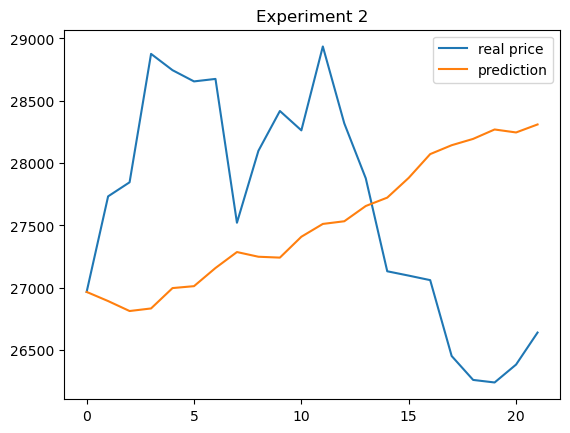

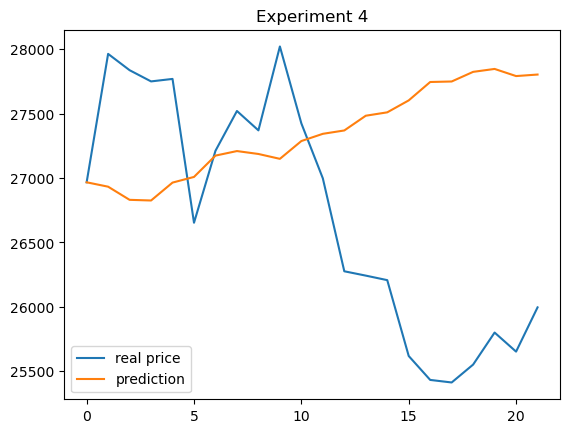

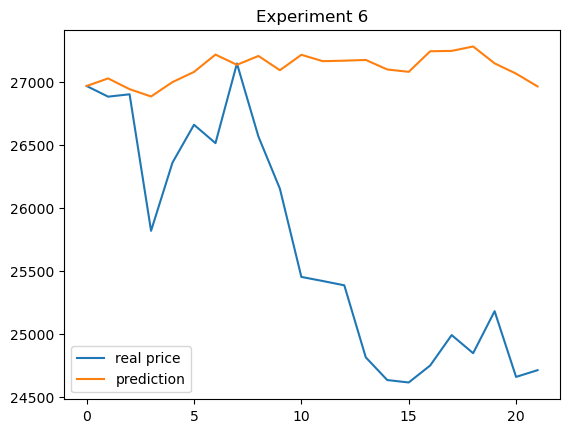

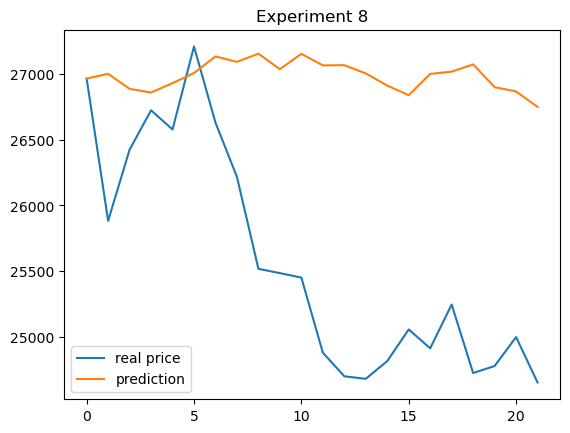

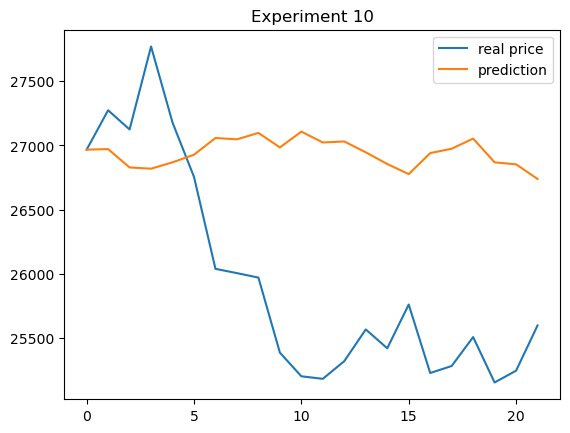

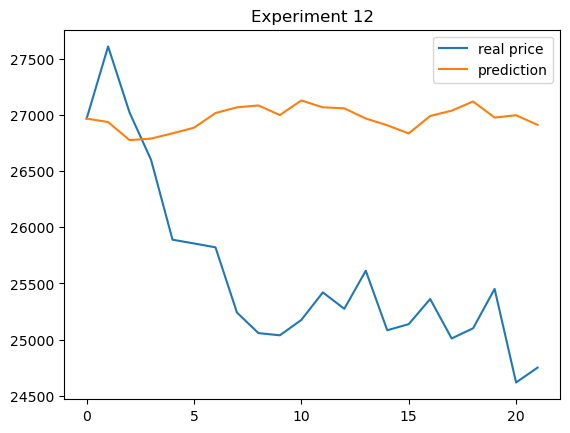

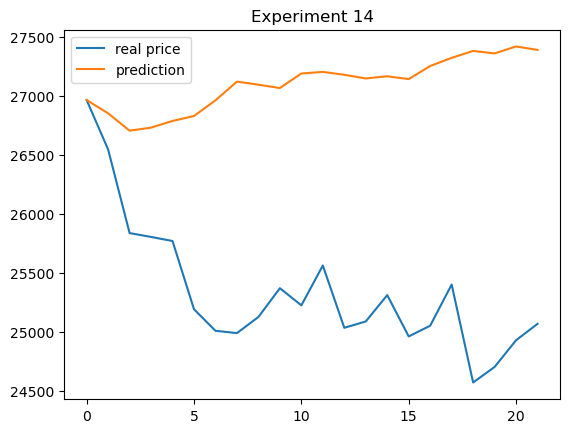

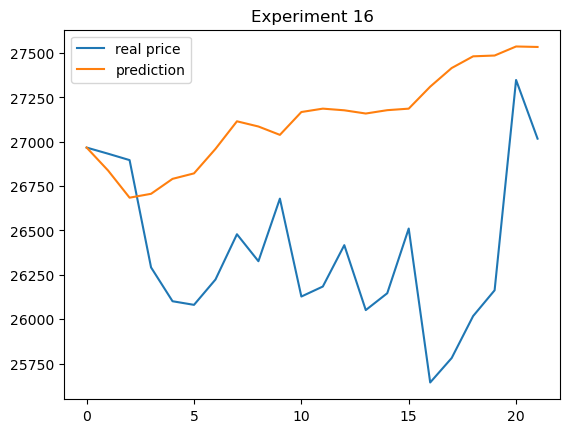

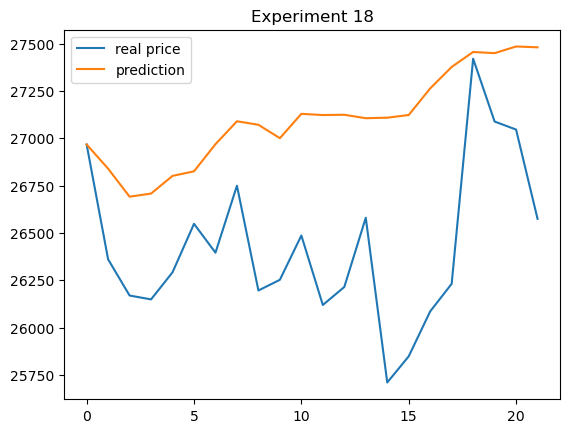

In [8]:
def test_predictions_multistep(preds, real, scaler, unscale=False, last_train=None, apply_func_to_preds=None, concat=False, step=1
):
    if concat:
        predictions = np.concatenate(preds)
    else:
        predictions = preds
    # if unscale:
    #     predictions = scaler.inverse_transform(predictions)
    #     real = scaler.inverse_transform(real)
    for i in range(0, predictions.shape[0] - 1, step):
        if unscale:
            unscaled_y_test = scaler.inverse_transform(real[i].reshape(-1, 1)).flatten()
            real_prices = [np.exp(last_train), *np.exp(last_train +  np.cumsum(unscaled_y_test))]


            prediction = apply_func_to_preds(predictions[i]) if apply_func_to_preds else predictions[i]
            unscaled_prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()
            #tmp = np.exp(last_train +  np.cumsum(unscaled_prediction))
            #print(prediction)
            kek = [np.exp(last_train), *np.exp(last_train +  np.cumsum(unscaled_prediction))]

            print(len(real_prices))
            print(len(kek))
            df = pd.DataFrame(data={"real price": real_prices, "prediction": kek})
        else:
            df = pd.DataFrame(data={"real price": real[i], "prediction": predictions[i]})
        #pd.DataFrame(data={"value": real[i], "prediction": predictions[i] * 10}).plot()
        df.plot(title=f'Experiment {i}')


train = df.iloc[:-ntest]
last_train = df.iloc[-1]['log_close']

#apply_func_to_preds = lambda x: x + x.mean()
apply_func_to_preds = lambda x: x * 10

test_predictions_multistep(
    preds, Ytest, scaler,  unscale=True, last_train=last_train, apply_func_to_preds=apply_func_to_preds,
    step=2
)